In [ ]:
### ok let's write the code now from top to bottom.
#--- necessary libraries ---#
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib

In [ ]:
#--- download, prepare the data ---#
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Define a transform to normalize the data to prepare the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                 train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 16586511.06it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299843.49it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5479157.97it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3159074.91it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    # making tensor i/p is flattened here itself
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

model = Classifier()
criterion = nn.NLLLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [ ]:
#--- Start the training ---#
epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set

        '''what we are doing is basically after each training loop
        we test the data present in the test set. '''
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))


<ipython-input-3-a0c4ce58f417>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc4(x))


Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.470..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.389..  Test Loss: 0.430..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.354..  Test Loss: 0.369..  Test Accuracy: 0.866
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.376..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.314..  Test Loss: 0.397..  Test Accuracy: 0.861
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.407..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.290..  Test Loss: 0.366..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.356..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.271..  Test Loss: 0.375..  Test Accuracy: 0.872
Epoch: 10/30..  Training Loss: 0.261..  Test Loss: 0.381..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.376..  Test Accuracy: 0.875
Epoch: 12/30..  Training Loss: 0.255..  Test Loss: 0.423..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.247.

In [ ]:
#--- A class which helps in visualizing data ---#
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(10,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap = 'gray',
               interpolation = 'bicubic')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


<ipython-input-3-a0c4ce58f417>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc4(x))


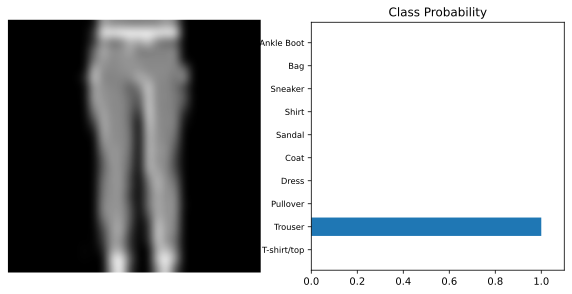

In [ ]:
#--- testing the trained model ---#
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import helper

dataiter_n = iter(testloader)
images, labels = next(dataiter_n)

# Convert 2D image to 1D vector
img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-prob, need to take exp for prob
prediction = torch.exp(logps)
view_classify(img.view(1, 28, 28), prediction,version='Fashion')


The model is trained so let's test the model.

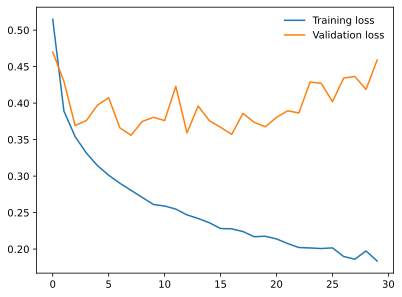

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)